# Some time series stuff

In [102]:
import matplotlib.pylab as plt
import matplotlib as m

%matplotlib inline

import pandas as pd
import numpy as np
import pickle as pickle

In [3]:
df_all = pickle.load(open('pickles/June_labeled_updated_fpl.p', 'rb'))

In [6]:
def setup(df):
    p = 0.75
    of_interest = df.predict_fpa > p

    df["first_person_alcohol"] = 0
    df["first_person_alcohol"][of_interest] = 1
    fp_cols = [ 'predict_present', 'predict_future', 'predict_past']
    new_fp_cols = ["casual", "looking", "reflecting"]
    for new_name, old_name in zip(new_fp_cols, fp_cols):
        df[new_name] = df[old_name] >0.6

In [7]:
setup(df_all)

C:\Users\Tom Work\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
week1 = df_all['2015-06-01':'2015-06-07']
week2 = df_all['2015-06-08':'2015-06-14']
week3 = df_all['2015-06-15':'2015-06-21']
week4 = df_all['2015-06-22':'2015-06-28']
week5 = df_all['2015-06-29':]
weeks = [week1, week2, week4]

In [264]:
temp = pd.DataFrame()
fpl = [df_all.casual, df_all.looking, df_all.reflecting]
by_hour = list()
for df in fpl:
    temp = df.groupby([df.index.dayofweek, df.index.hour]).agg(
        'mean'
    )
    by_hour.append(temp)

In [81]:
def cross_corr(ts1, ts2, lag=0):
    return ts1.corr(ts2.shift(lag))

In [175]:
by_hour[0].shape

(24,)

In [88]:
correlogram = [cross_corr(by_hour[0], by_hour[2], lag = i) for i in range(28)]

In [89]:
correlogram

[0.0033272979431857369,
 -0.00030799628860753213,
 0.0045487444935501577,
 0.013908704051362589,
 0.062354758147228781,
 0.11513747282593749,
 0.18735753901246258,
 0.23442860180845981,
 0.28164930380368897,
 0.38115088823079551,
 0.44636813037245981,
 0.52495690937754558,
 0.59851467897017341,
 0.67654546772965329,
 0.68747454998901691,
 0.67125142098435076,
 0.59726503643854267,
 0.49920190593989222,
 0.35670098302778275,
 0.23675955357669834,
 0.12141835317526314,
 0.015324150111422232,
 -0.070147256142134004,
 -0.12450179879798315,
 -0.16775430267852817,
 -0.2184951014349665,
 -0.24698590239740983,
 -0.25048511752817332]

In [98]:
def plot_correlogram(ts1, ts2, max_lag):
    def cross_corr(ts1, ts2, lag=0): return ts1.corr(ts2.shift(lag))
    correlogram = [cross_corr(ts1, ts2, lag = i) for i in range(max_lag)]
    plt.plot(range(max_lag), correlogram)
    plt.xticks(range(0, 24*7, 24))
    plt.grid()

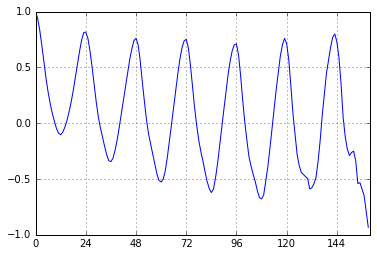

In [101]:
plot_correlogram(by_hour[0], by_hour[0], 160)

In [73]:
from scipy import signal

In [109]:
from statsmodels.tsa import stattools

In [111]:
periodogram = stattools.periodogram(by_hour[0])

In [113]:
help(stattools.periodogram)

Help on function periodogram in module statsmodels.tsa.stattools:

periodogram(X)
    Returns the periodogram for the natural frequency of X
    
    Parameters
    ----------
    X : array-like
        Array for which the periodogram is desired.
    
    Returns
    -------
    pgram : array
        1./len(X) * np.abs(np.fft.fft(X))**2
    
    
    References
    ----------
    Brockwell and Davis.



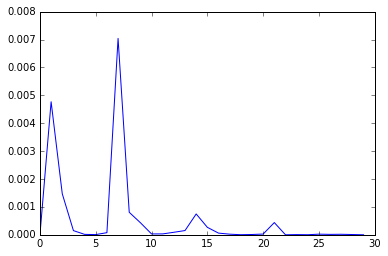

In [121]:
plt.plot(range(len(periodogram[:30])), periodogram[:30])

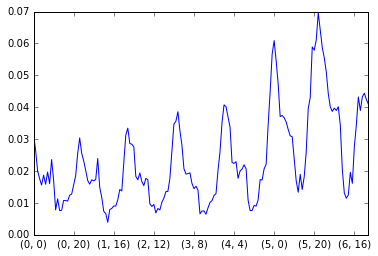

In [265]:
by_hour[0].plot()

# Naive Decomposition

We look at daily seasonality and trend over the week. Moving average trend

In [160]:
import statsmodels.api as sm

In [165]:
help(sm.tsa.seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, freq=None)
    Parameters
    ----------
    x : array-like
        Time series
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The default is a symmetric moving average.
    freq : int, optional
        Frequency of the series. Must be used if x is not a pandas
        object with a timeseries index.
    
    Returns
    -------
    results : obj
        A object with seasonal, trend, and resid attributes.
    
    Notes
    -----
    This is a naive decomposition. More sophisticated methods should
    be preferred.
    
    The additive model is Y[t] = T[t] + S[t] + e[t]
    
    The multiplicative model is Y[t] = T[t] * S[t] * e[t]
    
    The seasonal component is first removed by applying a con

In [282]:
res = sm.tsa.seasonal_decompose(by_hour[0].values, model='multiplicative', freq=24)
# res = sm.tsa.seasonal_decompose(by_hour[0].values, model='multiplicative', freq=24)

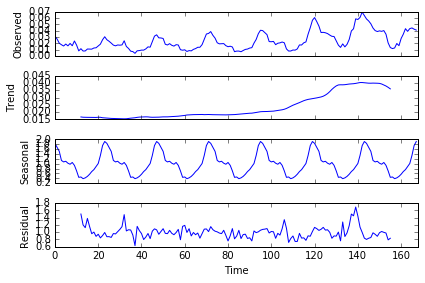

In [283]:
resplot = res.plot()

In [279]:
res.seasonal.shape

(168,)

# Residuals over 3 weeks:

In [324]:
df = pd.concat([week1.casual, week2.casual ,week4.casual])
casual =  df.groupby([df.index.day, df.index.hour]).agg(
        'mean'
    )

In [318]:
trend_mult = np.array(res.trend)
# trend_mult[np.isnan(res.trend)] = np.nanmean(trend_mult)
trend_mult

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.01671059,  0.01651594,  0.01644857,
        0.01644037,  0.01643406,  0.01640962,  0.01640103,  0.01637403,
        0.01648993,  0.01647321,  0.01618049,  0.01605989,  0.01595369,
        0.01578037,  0.01570887,  0.0156616 ,  0.01557444,  0.01550669,
        0.01544414,  0.01544444,  0.01543452,  0.0154798 ,  0.01568555,
        0.0158701 ,  0.0159972 ,  0.01616975,  0.01643263,  0.0166131 ,
        0.01666836,  0.01674153,  0.01678213,  0.01673778,  0.01656822,
        0.01648792,  0.01649424,  0.01648296,  0.01657425,  0.01669539,
        0.01676385,  0.01676089,  0.01677537,  0.01685148,  0.01695651,
        0.01699695,  0.01706814,  0.01723157,  0.01738198,  0.0174987 ,
        0.01775204,  0.01804722,  0.01814609,  0.01820806,  0.01829627,
        0.01832943,  0.01838189,  0.01845372,  0.01840116,  0.01

In [325]:
errs = casual/np.tile(res.seasonal*trend_mult, 3)

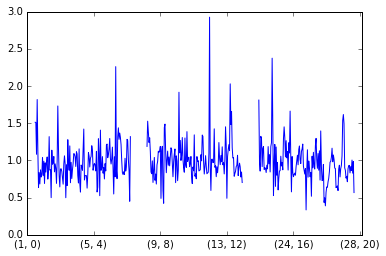

In [326]:
errs.plot()

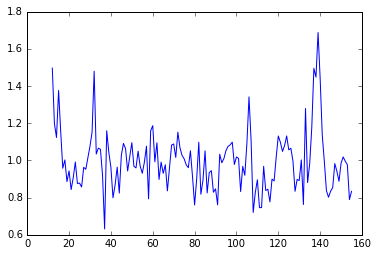

In [316]:
plt.plot(range(len(res.resid)), res.resid)